In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
# Image Reading
import cv2
from PIL import Image
# Data Plotting
import matplotlib.pylab as plt
# File Manager
from glob import glob
import os
# Hashing Images
import hashlib
import imagehash
# Display 
from IPython.display import display, HTML
# Model 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, VGG19


seting path for dataset

In [2]:
# path of original dataset
path_original = {
    'benign_test': 'melanoma_cancer_dataset/test/benign/*.jpg',
    'benign_train': 'melanoma_cancer_dataset/train/benign/*.jpg',
    'malignant_test': 'melanoma_cancer_dataset/test/malignant/*.jpg',
    'malignant_train': 'melanoma_cancer_dataset/train/malignant/*.jpg'
}


In [58]:
# Setting Path
unique_rgb_dataset = {
    'train': "unique/melanoma_cancer_dataset/train",
    'test': "unique/melanoma_cancer_dataset/test"
}
unique_normalize_gray_dataset ={
    'train': "unique/normalized_melanoma_cancer_dataset/train",
    'test': "unique/normalized_melanoma_cancer_dataset/test"
}
# Augmented
unique_augmented_rgb_dataset = {
    'train': "unique/augmented_melanoma_cancer_dataset/train",
    'test': "unique/melanoma_cancer_dataset/test"
}
unique_augmented_normalize_gray_dataset ={
    'train': "unique/normalized_augmented_melanoma_cancer_dataset/train",
    'test': "unique/normalized_melanoma_cancer_dataset/test"
}


# Project : Melanoma Cancer


## Part 1: Data Visualization and Pre Processing

In [4]:
def save_images(images, to, name):
    for i, image_path in enumerate(images):
        # Create the directory if it doesn't exist
        output_dir = os.path.join(to, name)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        try:
            # Read and resize the image
            with Image.open(image_path) as img:
                resized_image = img.resize((224, 224))
                # Save the resized image
                resized_image.save(os.path.join(output_dir, f'{name}_{i}.jpg'))
        except FileNotFoundError:
            print(f'File not found: {image_path}')
        except Exception as e:
            print(f'An error occurred: {e}')
    print('Saving process ended.')


In [35]:
# loading data set
benign_train = glob(path_original['benign_train'])
malignant_train = glob(path_original['malignant_train'])
benign_test = glob(path_original['benign_test'])
malignant_test = glob(path_original['malignant_test'])


In [6]:
# Checking the data distribution
data = {
      'Labels': ['Benign-Train', 'Benign-Test', 'Malignant-Train', 'Malignant-Test', 'Train', 'Test'],
      'Count': [len(benign_train), len(benign_test), len(malignant_train), len(malignant_test), len(benign_train) + len(malignant_train), len(benign_test) + len(malignant_test)]
}

df = pd.DataFrame(data)

display(HTML(df.to_html(index=False, border=2)))


Labels,Count
Benign-Train,5000
Benign-Test,500
Malignant-Train,4605
Malignant-Test,500
Train,9605
Test,1000


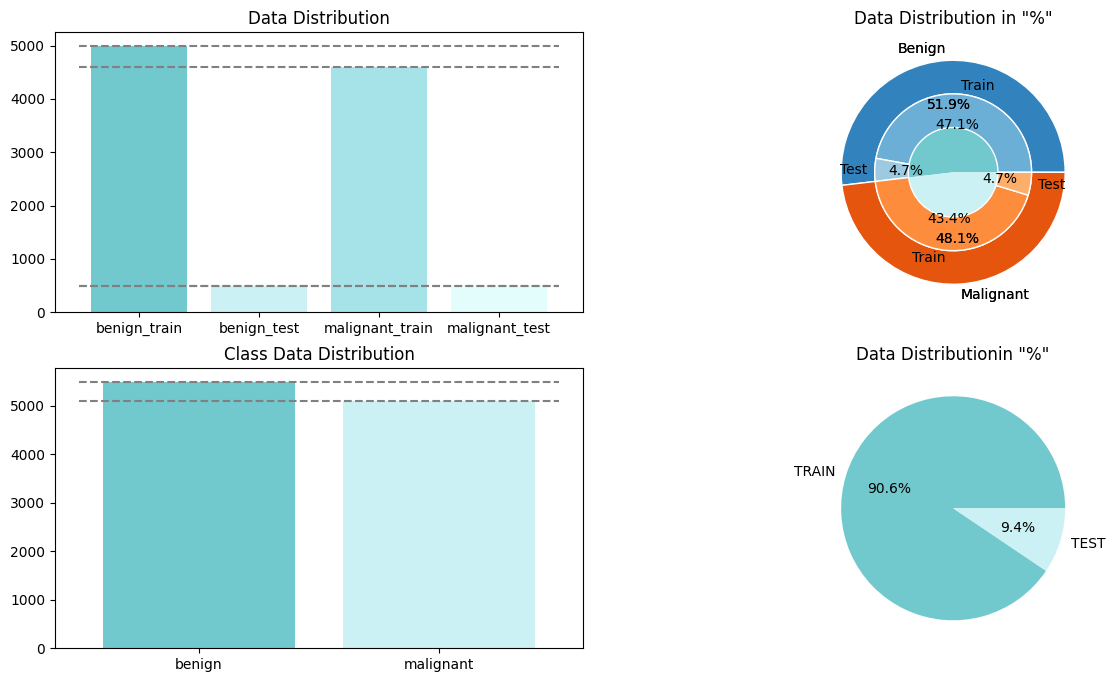

In [7]:
# visualizing the distribution
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0,0].bar(
    ['benign_train','benign_test','malignant_train','malignant_test'],
    [len(benign_train),len(benign_test),len(malignant_train),len(malignant_test)],
    color = ['#71C9CE', '#CBF1F5', '#A6E3E9',  '#E3FDFD']
    )
ax[0,0].set_title('Data Distribution')
ax[0,0].hlines(
    [len(benign_train),len(benign_test),len(malignant_train),len(malignant_test)],
    xmin=-0.5,
    xmax = 3.5,
    colors = 'gray', 
    linestyles = 'dashed'
    )

ax[0,1].pie(
    [len(benign_train) + len(benign_test), len(malignant_train) + len(malignant_test)],
    labels = ['Benign', 'Malignant'],
    colors = ['#71C9CE',  '#CBF1F5'],
    autopct='%1.1f%%'
)
ax[0,1].set_title('Data Distribution in "%"')
# Create a nested pie chart
size = 0.3
vals = np.array([[len(benign_train), len(benign_test)], [len(malignant_train), len(malignant_test)]])
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2) * 4)
inner_colors = cmap([1, 2, 5, 6])

ax[0,1].pie(vals.sum(axis=1), radius=1, colors=outer_colors, labels=['Benign', 'Malignant'], autopct='%1.1f%%', wedgeprops=dict(width=size, edgecolor='w'))
ax[0,1].pie(vals.flatten(), radius=1-size, colors=inner_colors, labels=['Train', 'Test', 'Train', 'Test'], autopct='%1.1f%%', wedgeprops=dict(width=size, edgecolor='w'))

ax[1,0].bar(
    ['benign','malignant'],
    [len(benign_train) + len(benign_test), len(malignant_train) + len(malignant_test)],
    color = ['#71C9CE', '#CBF1F5', '#A6E3E9',  '#E3FDFD']
    )
ax[1,0].set_title('Class Data Distribution')
ax[1,0].hlines(
    [len(benign_train) + len(benign_test), len(malignant_train) + len(malignant_test)],
    xmin=-0.5,
    xmax = 1.5,
    colors = 'gray', 
    linestyles = 'dashed'
    )

ax[1,1].pie(
    [len(benign_train) + len(malignant_train), len(benign_test) + len(malignant_test)],
    labels = ['TRAIN','TEST'],
    colors = ['#71C9CE',  '#CBF1F5'],
    autopct='%1.1f%%'
)
ax[1,1].set_title('Data Distributionin "%"')

plt.show()


**Inference**

1. Data distribution is approx 90% Treaning and 10% testing (from  *data distribution in "%*)
1. Data is slight imbalance (from *class data distribution*)

## Part 2: Duplicate Images

In [8]:
def find_duplicates(images_path):
    image_hashes = {}  # Store image hashes
    duplicates = []    # Store duplicate image paths
    unique = []        # Store unique image paths

    for image_path in images_path:
        try:
            with Image.open(image_path) as img:
                hash = imagehash.phash(img)  # Calculate perceptual hash
                if hash in image_hashes:
                    duplicates.append((image_hashes[hash], image_path))  # Store duplicate
                else:
                    unique.append(image_path)
                    image_hashes[hash] = image_path  # Store unique hash
        except Exception as e:
            if e == "name 'imagehash' is not defined":
                print('Plaese import imagehash')
                break
            print(f"Error processing image: {image_path}, error: {e}")

    return duplicates, unique


In [36]:
# Sorting Duplicate and Unique
duplicate_benign_train, unique_benign_train = find_duplicates(benign_train)
duplicate_benign_test, unique_benign_test = find_duplicates(benign_test)
duplicate_malignant_train, unique_malignant_train = find_duplicates(malignant_train)
duplicate_malignant_test, unique_malignant_test = find_duplicates(malignant_test)


In [ ]:
save_images(unique_benign_test, unique_rgb_dataset['test']'/benign','benign')
save_images(unique_malignant_test, unique_rgb_dataset['test']'/malignant','malignant')
save_images(unique_benign_train, unique_rgb_dataset['train']'/benign','benign')
save_images(unique_malignant_train, unique_rgb_dataset['train']'/malignant','malignant')


Saving process ended.
Saving process ended.
Saving process ended.
Saving process ended.


Labels,Duplicate Count
Benign-Train,8
Benign-Test,1
Malignant-Train,18
Malignant-Test,0


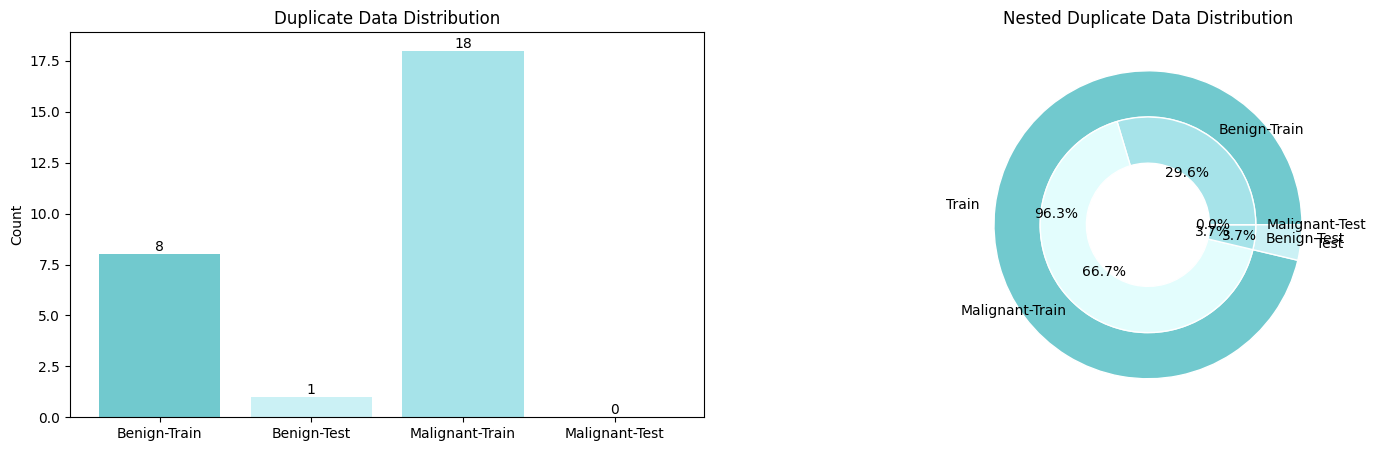

In [12]:
# Creating a DataFrame to display the counts of duplicate images
duplicate_data = {
    'Labels': ['Benign-Train', 'Benign-Test', 'Malignant-Train', 'Malignant-Test'],
    'Duplicate Count': [len(duplicate_benign_train), len(duplicate_benign_test), len(duplicate_malignant_train), len(duplicate_malignant_test)]
}

duplicate_df = pd.DataFrame(duplicate_data)
display(HTML(duplicate_df.to_html(index=False, border=2)))

# Visualizing the duplicate data distribution
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Bar plot for duplicate data distribution
bars = ax[0].bar(
    ['Benign-Train', 'Benign-Test', 'Malignant-Train', 'Malignant-Test'],
    [len(duplicate_benign_train), len(duplicate_benign_test), len(duplicate_malignant_train), len(duplicate_malignant_test)],
    color=['#71C9CE', '#CBF1F5', '#A6E3E9', '#E3FDFD']
)
ax[0].set_title('Duplicate Data Distribution')
ax[0].set_ylabel('Count')

# Adding text on top of the bars
for bar in bars:
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Nested pie chart for duplicate data distribution showing percentages
size = 0.3
vals = np.array([[len(duplicate_benign_train), len(duplicate_malignant_train)], [len(duplicate_benign_test), len(duplicate_malignant_test)]])
outer_colors = ['#71C9CE', '#CBF1F5']
inner_colors = ['#A6E3E9', '#E3FDFD', '#A6E3E9', '#E3FDFD']

ax[1].pie(
    vals.sum(axis=1), 
    radius=1, 
    colors=outer_colors, 
    labels=['Train', 'Test'], 
    autopct='%1.1f%%', 
    wedgeprops=dict(width=size, 
    edgecolor='w')
)
ax[1].pie(
    vals.flatten(), 
    radius=1-size, 
    colors=inner_colors, 
    labels=['Benign-Train', 
    'Malignant-Train', 
    'Benign-Test', 
    'Malignant-Test'], 
    autopct='%1.1f%%', 
    wedgeprops=dict(width=size, edgecolor='w')
)
ax[1].set_title('Nested Duplicate Data Distribution')

plt.show()


**Inference**

1. Duplicate images are present.
1. We can remove duplicate images as it will not affect the data size as much.
1. Duplicat distribution 
    **Train = 26,
    Test = 1**.

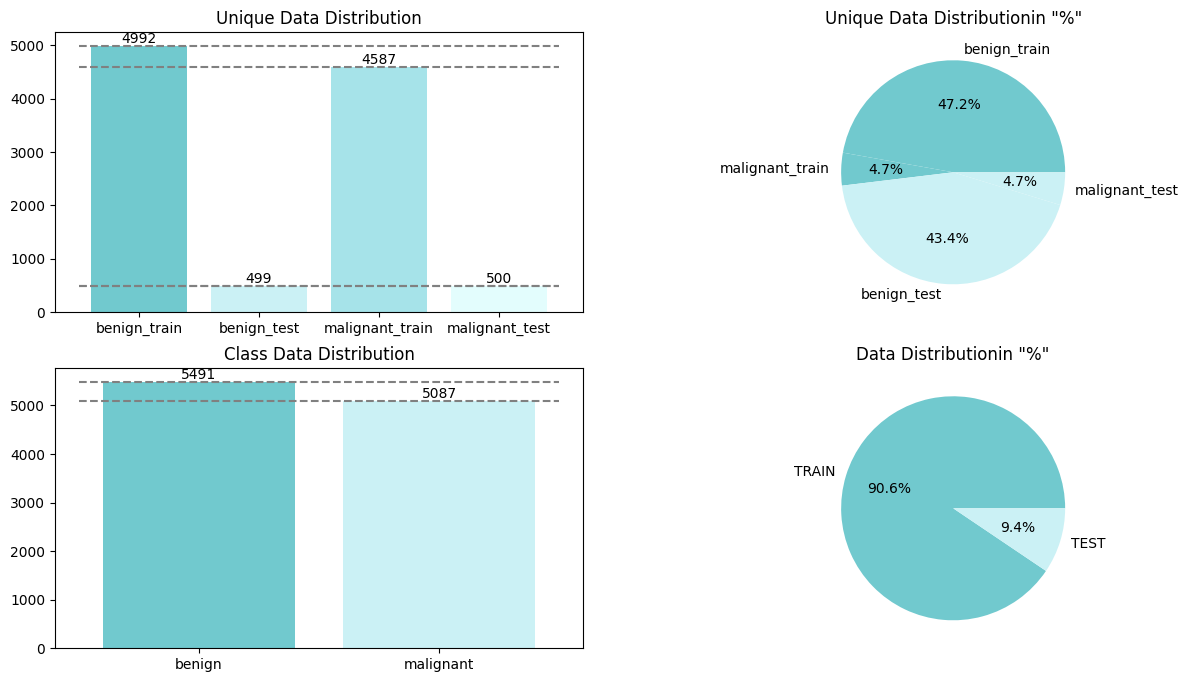

In [13]:
# visualizing the UNIQUE data distribution
fig, ax = plt.subplots(2,2,figsize=(15,8))
unique_counts = [len(unique_benign_train), len(unique_benign_test), len(unique_malignant_train), len(unique_malignant_test)]

# Bar chart for unique data distribution
bars = ax[0,0].bar(
    ['benign_train','benign_test','malignant_train','malignant_test'],
    unique_counts,
    color = ['#71C9CE', '#CBF1F5', '#A6E3E9',  '#E3FDFD']
)
ax[0,0].set_title('Unique Data Distribution')
ax[0,0].hlines(
    unique_counts,
    xmin=-0.5,
    xmax = 3.5,
    colors = 'gray', 
    linestyles = 'dashed'
)

# Adding text on top of the bars
for bar in bars:
    height = bar.get_height()
    ax[0,0].text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Pie chart for unique data distribution
ax[0,1].pie(
    unique_counts,
    labels = ['benign_train','malignant_train','benign_test','malignant_test'],
    colors = ['#71C9CE', '#71C9CE', '#CBF1F5',  '#CBF1F5'],
    autopct='%1.1f%%'
)
ax[0,1].set_title('Unique Data Distributionin "%"')

# Bar chart for class data distribution
class_counts = [len(unique_benign_train) + len(unique_benign_test), len(unique_malignant_train) + len(unique_malignant_test)]
bars = ax[1,0].bar(
    ['benign','malignant'],
    class_counts,
    color = ['#71C9CE', '#CBF1F5', '#A6E3E9',  '#E3FDFD']
)
ax[1,0].set_title('Class Data Distribution')
ax[1,0].hlines(
    class_counts,
    xmin=-0.5,
    xmax = 1.5,
    colors = 'gray', 
    linestyles = 'dashed'
)

# Adding text on top of the bars
for bar in bars:
    height = bar.get_height()
    ax[1,0].text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Pie chart for train/test data distribution
train_test_counts = [len(unique_benign_train) + len(unique_malignant_train), len(unique_benign_test) + len(unique_malignant_test)]
ax[1,1].pie(
    train_test_counts,
    labels = ['TRAIN','TEST'],
    colors = ['#71C9CE',  '#CBF1F5'],
    autopct='%1.1f%%'
)
ax[1,1].set_title('Data Distributionin "%"')

plt.show()


**Inference**

1. There is only an small change in data distribution
1. The change is negligable

In [46]:
conclusion = f'''
| Labels          | Original | Duplicate | Unique |
|-----------------|----------|-----------|--------|
| Benign-Train    |   {len(benign_train)}   |    {len(duplicate_benign_train)}      |  {len(unique_benign_train)}  |
| Benign-Test     |   {len(benign_test)}    |    {len(duplicate_benign_test)}      |  {len(unique_benign_test)}   |
| Malignant-Train |   {len(malignant_train)}   |    {len(duplicate_malignant_train)}     |  {len(unique_malignant_train)}  |
| Malignant-Test  |   {len(malignant_test)}    |    {len(duplicate_malignant_test)}      |  {len(unique_malignant_test)}   |
|-----------------|----------|-----------|--------|
| Train           |   {len(benign_train) + len(malignant_train)}   |     {len(duplicate_benign_train) + len(duplicate_malignant_train)}    |   {len(unique_benign_train) + len(unique_malignant_train)} |
| Test            |   {len(benign_test) + len(malignant_test)}   |     {len(duplicate_benign_test) + len(duplicate_malignant_test)}     |   {len(unique_benign_test) + len(unique_malignant_test)}  |
'''

print(conclusion)



| Labels          | Original | Duplicate | Unique |
|-----------------|----------|-----------|--------|
| Benign-Train    |   5000   |    8      |  4992  |
| Benign-Test     |   500    |    1      |  499   |
| Malignant-Train |   4605   |    18     |  4587  |
| Malignant-Test  |   500    |    0      |  500   |
|-----------------|----------|-----------|--------|
| Train           |   9605   |     26    |   9579 |
| Test            |   1000   |     1     |   999  |



## Part 3: Noarmalizing and Gray Scalling

In [17]:
def Normalize_Gray_img(images_path):
    update_images = []
    for image_path in images_path:
        image = plt.imread(image_path)
        # Converting to Gray.
        image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        # Normalizing Image.
        normalize_image = image_gray / 255
        update_images.append(normalize_image)
    print("Normalization & Gray Process End...x...")
    return update_images


In [18]:
# Normalizing and Gray Scalling
unique_benign_test_N_G = Normalize_Gray_img(unique_benign_test)
unique_benign_train_N_G = Normalize_Gray_img(unique_benign_train)
unique_malignant_test_N_G = Normalize_Gray_img(unique_malignant_test)
unique_malignant_train_N_G = Normalize_Gray_img(unique_malignant_train)


Normalization & Gray Process End...x...
Normalization & Gray Process End...x...
Normalization & Gray Process End...x...
Normalization & Gray Process End...x...


## Part 4: Saving Unique, Noarmalize - Gray - Unique Data

In [19]:
def save(images, to, name):
    for i, image_path in enumerate(images):
        # Create the directory if it doesn't exist
        output_dir = to
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        try:
            # Read and save the image
            image = image_path
            plt.imsave(os.path.join(output_dir, f'{name}_{i}.jpg'), image)
        except FileNotFoundError:
            print(f'File not found: {image_path}')
        except Exception as e:
            print(f'An error occurred: {e}')
    print('Saving process ended...x...')


In [ ]:
# Unique Normalize Gray dataset
save(unique_benign_train_N_G,unique_normalize_gray_dataset['train']+'/benign', 'benign')
save(unique_benign_test_N_G,unique_normalize_gray_dataset['test']+'/benign', 'benign')
save(unique_malignant_train_N_G,unique_normalize_gray_dataset['train']+'/malignant', 'malignant')
save(unique_malignant_test_N_G,unique_normalize_gray_dataset['test']+'/malignant', 'malignant')


Saving process ended...x...
Saving process ended...x...
Saving process ended...x...
Saving process ended...x...


## Part 5: Data Augmentation

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def augment_images(image_paths, save_to_dir, prefix, num_augmented=5):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant',  
        cval=0 
    )

    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    for idx, image_path in enumerate(image_paths):
        img = load_img(image_path)  # Load image
        x = img_to_array(img)  # Convert image to numpy array
        x = x.reshape((1,) + x.shape)  # Reshape image

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=save_to_dir, save_prefix=f'img{idx+1}_arg', save_format='jpg'):
            i += 1
            if i >= num_augmented:
                break  # Stop after generating num_augmented images
    print("Process Completed...X...")


**Augmentation of Unique RGB Dataset**

In [ ]:
image_paths = glob(unique_rgb_dataset['train']+'/benign/*.jpg') # Replace with your image paths
save_path = unique_augmented_rgb_dataset['train']+'/benign'
augment_images(image_paths, save_path, 'benign', num_augmented=5)

image_paths = glob(unique_rgb_dataset['train']+'/malignant/*.jpg') # Replace with your image paths
save_path = unique_augmented_rgb_dataset['train']+'/malignant'
augment_images(image_paths, save_path, 'malignant', num_augmented=5)


Process Completed...X...


**Augmentation of Normalize Gray Unique Dataset**

In [ ]:
image_paths = glob(unique_normalize_gray_dataset['train']+'/benign/*.jpg') # Replace with your image paths
save_path = unique_augmented_normalize_gray_dataset['train']+'/benign'
augment_images(image_paths, save_path, 'benign', num_augmented=5)

image_paths = glob(unique_normalize_gray_dataset['train']+'/malignant/*.jpg') # Replace with your image paths
save_path = unique_augmented_normalize_gray_dataset['train']+'/malignant'
augment_images(image_paths, save_path, 'malignant', num_augmented=5)


Process Completed...X...
Process Completed...X...


Benign Image and its Augmentations:


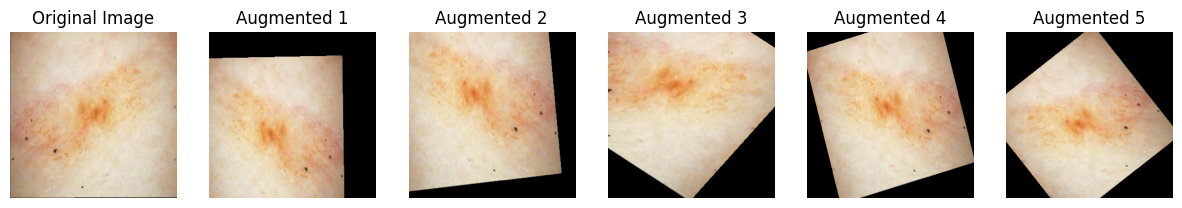

Malignant Image and its Augmentations:


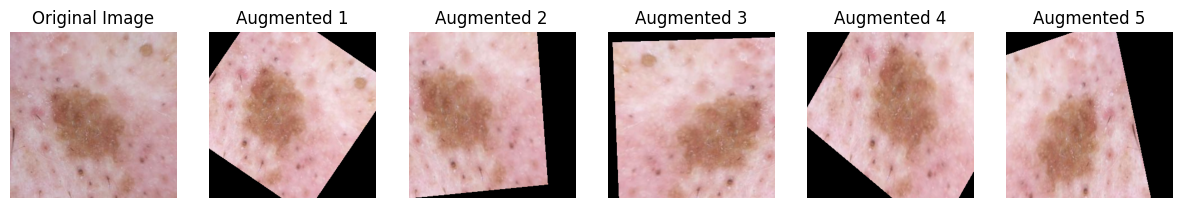

In [28]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def display_augmented_images(image_paths, num_augmented=5):
    # Select a random image from the list
    random_image_path = random.choice(image_paths)
    
    # Load the selected image
    img = load_img(random_image_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    
    # Create an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant',  
        cval=0 
    )
    
    # Display the original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_augmented + 1, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Generate and display augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        i += 1
        plt.subplot(1, num_augmented + 1, i + 1)
        plt.imshow(array_to_img(batch[0]))
        plt.title(f'Augmented {i}')
        plt.axis('off')
        if i >= num_augmented:
            break

# Display augmented images for a random benign image
print("Benign Image and its Augmentations:")
display_augmented_images(unique_benign_train, num_augmented=5)
plt.show()

# Display augmented images for a random malignant image
print("Malignant Image and its Augmentations:")
display_augmented_images(unique_malignant_train, num_augmented=5)
plt.show()


# Model

## CNN Models
1. unique rgb
1. unique normalize gray
1. unique augmented rgb
1. unique augmented normalize gray 

Defining Model

In [ ]:
def CNN_Model1(train_dir, test_dir, epochs, model_name):
    # Create the training and validation generators (assuming data is already augmented)
    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        class_mode='binary'
    )

    validation_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        class_mode='binary'
    )

    # Improved model architecture with more depth, batch normalization, and L2 regularization
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),  # Dropout for regularization

        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model with an adaptive learning rate optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True, 
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3, 
        min_lr=1e-6, 
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    
    if not os.path.exists('UI/static/models'):
        os.makedirs('UI/static/models')

    # Save the model
    model_name = f'{model_name}.keras'
    model.save(f'UI/static/models/{model_name}')

    return model, history


In [ ]:
def CNN_Model2(train_dir, test_dir, epochs, model_name):
    # Create the training and validation generators (assuming data is already augmented)
    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        color_mode='grayscale',
        batch_size=32,
        class_mode='binary'
    )

    validation_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        color_mode='grayscale',
        batch_size=32,
        class_mode='binary'
    )

    # Improved model architecture with more depth, batch normalization, and L2 regularization
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),  # Dropout for regularization

        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model with an adaptive learning rate optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True, 
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3, 
        min_lr=1e-6, 
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    
    if not os.path.exists('UI/static/models'):
        os.makedirs('UI/static/models')

    # Save the model
    model_name = f'{model_name}.keras'
    model.save(f'UI/static/models/{model_name}')

    return model, history


### unique_rgb_modle

In [ ]:
Unique_RGB_Model, Unique_RGB_Model_History = CNN_Model1(unique_rgb_dataset['train'],unique_rgb_dataset['test'], 10, 'final_Unique_RGB_Model')


Found 9579 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.8368 - loss: 9.9365 - val_accuracy: 0.5005 - val_loss: 10.3401 - learning_rate: 1.0000e-04
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.8841 - loss: 5.7095 - val_accuracy: 0.8819 - val_loss: 3.9692 - learning_rate: 1.0000e-04
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.9110 - loss: 3.4999 - val_accuracy: 0.9029 - val_loss: 2.5252 - learning_rate: 1.0000e-04
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.9092 - loss: 2.2600 - val_accuracy: 0.9059 - val_loss: 1.7045 - learning_rate: 1.0000e-04
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.9160 - loss: 1.5364 - val_accuracy: 0.8879 - val_loss: 1.2316 - learning_rate: 1.0000e-04
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.9307 - loss: 1.0836 - val_accuracy: 0.9009 - val_loss: 1.0324 - 

### unique_normalize_gray_dataset

In [ ]:
Unique_Normalize_Gray_Model, Unique_Normalize_Gray_Model_History = CNN_Model2(unique_normalize_gray_dataset['train'],unique_normalize_gray_dataset['test'], 100, 'final_Unique_Normalize_Gray_Model')


Found 9579 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


d:\Abhijeet\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Abhijeet\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 291s 946ms/step - accuracy: 0.7852 - loss: 9.7398 - val_accuracy: 0.5576 - val_loss: 6.7941 - learning_rate: 1.0000e-04
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.8766 - loss: 5.2554 - val_accuracy: 0.8559 - val_loss: 3.5773 - learning_rate: 1.0000e-04
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 264s 880ms/step - accuracy: 0.9023 - loss: 3.0953 - val_accuracy: 0.8428 - val_loss: 2.3689 - learning_rate: 1.0000e-04
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 248s 827ms/step - accuracy: 0.9123 - loss: 1.9638 - val_accuracy: 0.8418 - val_loss: 1.6089 - learning_rate: 1.0000e-04
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 246s 820ms/step - accuracy: 0.9209 - loss: 1.3707 - val_accuracy: 0.8949 - val_loss: 1.1758 - learning_rate: 1.0000e-04
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 246s 820ms/step - accuracy: 0.9226 - loss: 1.0595 - val_accuracy: 0.8989 - val_loss: 0.9849 - learning_rate: 1.0000e-04
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━

### unique_augmented_rgb_dataset

In [ ]:
Unique_Augmented_RGB_Model, Unique_Augmented_RGB_Model_History = CNN_Model1(unique_augmented_rgb_dataset['train'],unique_augmented_rgb_dataset['test'], 100, 'final_Unique_Augmented_RGB_Model')


Found 47892 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Epoch 1/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1426s 951ms/step - accuracy: 0.8271 - loss: 6.4399 - val_accuracy: 0.7548 - val_loss: 1.5406 - learning_rate: 1.0000e-04
Epoch 2/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1649s 1s/step - accuracy: 0.8739 - loss: 0.9726 - val_accuracy: 0.6046 - val_loss: 2.1535 - learning_rate: 1.0000e-04
Epoch 3/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1661s 1s/step - accuracy: 0.8854 - loss: 0.6911 - val_accuracy: 0.5485 - val_loss: 4.1857 - learning_rate: 1.0000e-04
Epoch 4/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 3545s 2s/step - accuracy: 0.8918 - loss: 0.6271 - val_accuracy: 0.7658 - val_loss: 1.2416 - learning_rate: 1.0000e-04
Epoch 5/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1352s 903ms/step - accuracy: 0.9002 - loss: 0.5666 - val_accuracy: 0.7097 - val_loss: 2.2431 - learning_rate: 1.0000e-04
Epoch 6/100
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1925s 1s/step - accuracy: 0.9068 - loss: 0.5221 - val_accuracy

### unique_augmented_normalize_gray_dataset

In [ ]:
Unique_Augmented_Normalize_Gray_Model, Unique_Augmented_Normalize_Gray_Model_History = CNN_Model2(unique_augmented_normalize_gray_dataset['train'],unique_augmented_normalize_gray_dataset['test'], 5, 'final_Unique_Augmented_Normalize_Gray_Model')


Found 47885 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Epoch 1/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 2188s 1s/step - accuracy: 0.7542 - loss: 6.6368 - val_accuracy: 0.8829 - val_loss: 1.2337 - learning_rate: 1.0000e-04
Epoch 2/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1715s 1s/step - accuracy: 0.8390 - loss: 1.0888 - val_accuracy: 0.8048 - val_loss: 0.9457 - learning_rate: 1.0000e-04
Epoch 3/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1252s 837ms/step - accuracy: 0.8568 - loss: 0.7647 - val_accuracy: 0.7457 - val_loss: 1.1103 - learning_rate: 1.0000e-04
Epoch 4/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1526s 1s/step - accuracy: 0.8696 - loss: 0.7058 - val_accuracy: 0.9009 - val_loss: 0.6582 - learning_rate: 1.0000e-04
Epoch 5/5
1497/1497 ━━━━━━━━━━━━━━━━━━━━ 1504s 1s/step - accuracy: 0.8779 - loss: 0.6834 - val_accuracy: 0.8018 - val_loss: 0.9757 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 4.


## VGG Models

In [ ]:
def train_and_test_vgg_model(train_dir, test_dir, img_size=(224, 224), batch_size=32, epochs=10, model_type='VGG16', model_save_path='saved_model.h5'):
    """
    Function to train and test VGG model (VGG16 or VGG19) on an RGB melanoma dataset and save the trained model.

    Args:
    - train_dir: str, path to the training data directory.
    - test_dir: str, path to the test data directory.
    - img_size: tuple, image size for resizing images (default is 224x224).
    - batch_size: int, batch size for training (default is 32).
    - epochs: int, number of epochs for training (default is 10).
    - model_type: str, either 'VGG16' or 'VGG19' (default is 'VGG16').
    - model_save_path: str, path to save the trained model (default is 'saved_model.h5').

    Returns:
    - model: trained Keras model.
    - history: training history.
    """

    # Load the train and test data from the directories
    train_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation, data is already augmented
    test_datagen = ImageDataGenerator(rescale=1./255)   # No augmentation, data is already normalized

    # Load images and labels from directories
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',  # Assuming binary classification (melanoma vs non-melanoma)
        color_mode='rgb'  # RGB color mode (3 channels)
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',  # Assuming binary classification (melanoma vs non-melanoma)
        color_mode='rgb'  # RGB color mode (3 channels)
    )

    # Select the model (VGG16 or VGG19)
    if model_type == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    elif model_type == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    else:
        raise ValueError("model_type should be either 'VGG16' or 'VGG19'")

    # Freeze the layers of the VGG base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=test_generator.samples // batch_size
    )

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    if not os.path.exists('UI/static/models'):
        os.makedirs('UI/static/models')

    # Save the trained model
    model.save('UI/static/models/'+model_save_path)
    print(f"Model saved to UI/static/models/{model_save_path}")

    # Return the trained model and training history
    return model, history


#### VGG 16

In [ ]:
train_dir = 'unique/unique/augmented_melanoma_cancer_dataset/train'
test_dir = 'unique/unique/melanoma_cancer_dataset/test'

# Choose the model type: 'VGG16'
model_type = 'VGG16'  

# Specify the path where the model will be saved
model_save_path = 'vgg16_melanoma_model.keras'

model, history = train_and_test_vgg_model(
    train_dir, 
    test_dir, 
    epochs=2, 
    model_type=model_type, 
    model_save_path=model_save_path
)


Found 47892 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 32s 1us/step


d:\Abhijeet\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 7886s 5s/step - accuracy: 0.8075 - loss: 0.5479 - val_accuracy: 0.8599 - val_loss: 0.3364
Epoch 2/2
   1/1496 ━━━━━━━━━━━━━━━━━━━━ 53:37 2s/step - accuracy: 0.8438 - loss: 0.4980

C:\Program Files\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1496/1496 ━━━━━━━━━━━━━━━━━━━━ 3s 347us/step - accuracy: 0.8438 - loss: 0.4980 - val_accuracy: 1.0000 - val_loss: 0.0469
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.8652 - loss: 0.3388
Test Accuracy: 0.8579
Model saved to vgg16_melanoma_model.keras


#### VGG 19

In [ ]:
train_dir = 'unique/unique/augmented_melanoma_cancer_dataset/train'
test_dir = 'unique/unique/melanoma_cancer_dataset/test'

# Choose the model type: 'VGG16'
model_type = 'VGG19'

# Specify the path where the model will be saved
model_save_path = 'vgg19_melanoma_model.keras'

model, history = train_and_test_vgg_model(
    train_dir, 
    test_dir, 
    epochs=2, 
    model_type=model_type, 
    model_save_path=model_save_path
)


Found 47892 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Epoch 1/2
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 8210s 5s/step - accuracy: 0.7959 - loss: 0.5730 - val_accuracy: 0.8327 - val_loss: 0.3847
Epoch 2/2
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 3s 437us/step - accuracy: 0.8750 - loss: 0.3147 - val_accuracy: 0.8571 - val_loss: 0.5556
32/32 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8426 - loss: 0.3883
Test Accuracy: 0.8338
Model saved to vgg19_melanoma_model.keras


# Finalizing Best Model 

In [47]:
# Load all the models
unique_rgb_model = tf.keras.models.load_model('UI/static/models/final_Unique_RGB_Model.keras')
unique_normalize_gray_model = tf.keras.models.load_model('UI/static/models/final_Unique_Normalize_Gray_Model.keras')
unique_augmented_rgb_model = tf.keras.models.load_model('UI/static/models/final_Unique_Augmented_RGB_Model.keras')
unique_augmented_normalize_gray_model = tf.keras.models.load_model('UI/static/models/final_Unique_Augmented_Normalize_Gray_Model.keras')
vgg16_model = tf.keras.models.load_model('UI/static/models/vgg16_melanoma_model.keras')
vgg19_model = tf.keras.models.load_model('UI/static/models/vgg19_melanoma_model.keras')

print("All models loaded successfully.")


All models loaded successfully.


In [ ]:
from sklearn.metrics import f1_score

# Define a function to evaluate the models and store the results
def evaluate_model(model, test_dir):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        color_mode='rgb' if model.input_shape[-1] == 3 else 'grayscale',
        shuffle=False
    )
    
    # Get the true labels and predictions
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    # Calculate loss and accuracy
    loss, accuracy = model.evaluate(test_generator)
    
    # Calculate F1 scores for both classes
    f1_benign = f1_score(true_labels, predicted_labels, pos_label=0)
    f1_malignant = f1_score(true_labels, predicted_labels, pos_label=1)
    
    # Round the results to two decimal places
    loss = round(loss, 2)
    accuracy = round(accuracy, 2)
    f1_benign = round(f1_benign, 2)
    f1_malignant = round(f1_malignant, 2)
    
    return loss, accuracy, f1_benign, f1_malignant

# Evaluate each model and store the results in a dictionary
evaluation_results = {
    'Model': [],
    'Loss': [],
    'Accuracy': [],
    'F1_Benign': [],
    'F1_Malignant': []
}

models = {
    'Unique_RGB_Model': unique_rgb_model,
    'Unique_Normalize_Gray_Model': unique_normalize_gray_model,
    'Unique_Augmented_RGB_Model': unique_augmented_rgb_model,
    'Unique_Augmented_Normalize_Gray_Model': unique_augmented_normalize_gray_model,
    'VGG16_Model': vgg16_model,
    'VGG19_Model': vgg19_model
}

for model_name, model in models.items():
    if 'Normalize_Gray' in model_name:
        test_dir = unique_normalize_gray_dataset['test']
    elif 'Augmented_RGB' in model_name:
        test_dir = unique_augmented_rgb_dataset['test']
    elif 'Augmented_Normalize_Gray' in model_name:
        test_dir = unique_augmented_normalize_gray_dataset['test']
    else:
        test_dir = unique_rgb_dataset['test']
    
    loss, accuracy, f1_benign, f1_malignant = evaluate_model(model, test_dir)
    evaluation_results['Model'].append(model_name)
    evaluation_results['Loss'].append(loss)
    evaluation_results['Accuracy'].append(accuracy)
    evaluation_results['F1_Benign'].append(f1_benign)
    evaluation_results['F1_Malignant'].append(f1_malignant)

# Create a DataFrame from the evaluation results
evaluation_df = pd.DataFrame(evaluation_results)

# Save the evaluation_df DataFrame to 'UI/static' directory
evaluation_df.to_csv('UI/static/evaluation_results.csv', index=False)

# Display the DataFrame
print(evaluation_df)


Found 999 images belonging to 2 classes.


e:\video converter\.melanoma_cancer_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 585ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 565ms/step - accuracy: 0.8530 - loss: 0.8277
Found 999 images belonging to 2 classes.


e:\video converter\.melanoma_cancer_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 526ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 559ms/step - accuracy: 0.9221 - loss: 0.6028
Found 999 images belonging to 2 classes.


e:\video converter\.melanoma_cancer_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 544ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 568ms/step - accuracy: 0.6731 - loss: 1.6718
Found 999 images belonging to 2 classes.


e:\video converter\.melanoma_cancer_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 627ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 636ms/step - accuracy: 0.9271 - loss: 0.7133
Found 999 images belonging to 2 classes.


e:\video converter\.melanoma_cancer_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 219s 7s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 208s 6s/step - accuracy: 0.8630 - loss: 0.3693
Found 999 images belonging to 2 classes.


e:\video converter\.melanoma_cancer_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 270s 8s/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 269s 8s/step - accuracy: 0.8275 - loss: 0.4386
                                   Model  Loss  Accuracy  F1_Benign  \
0                       Unique_RGB_Model  0.77      0.88       0.88   
1            Unique_Normalize_Gray_Model  0.66      0.90       0.90   
2             Unique_Augmented_RGB_Model  1.24      0.77       0.73   
3  Unique_Augmented_Normalize_Gray_Model  0.81      0.91       0.91   
4                            VGG16_Model  0.34      0.86       0.86   
5                            VGG19_Model  0.39      0.83       0.83   

   F1_Malignant  
0          0.88  
1          0.90  
2          0.80  
3          0.91  
4          0.86  
5          0.84  


In [66]:
from sklearn.metrics import classification_report

def print_classification_report(model, test_dir):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        color_mode='rgb' if model.input_shape[-1] == 3 else 'grayscale',
        shuffle=False
    )
    
    # Get the true labels and predictions
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    # Print the classification report
    report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys())
    print(report)

# Print classification report for one of the models, e.g., Unique_RGB_Model
print_classification_report(unique_augmented_normalize_gray_model, unique_augmented_normalize_gray_dataset['test'])


Found 999 images belonging to 2 classes.


e:\video converter\.melanoma_cancer_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 784ms/step
              precision    recall  f1-score   support

      benign       0.88      0.93      0.90       499
   malignant       0.93      0.87      0.90       500

    accuracy                           0.90       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.90      0.90      0.90       999



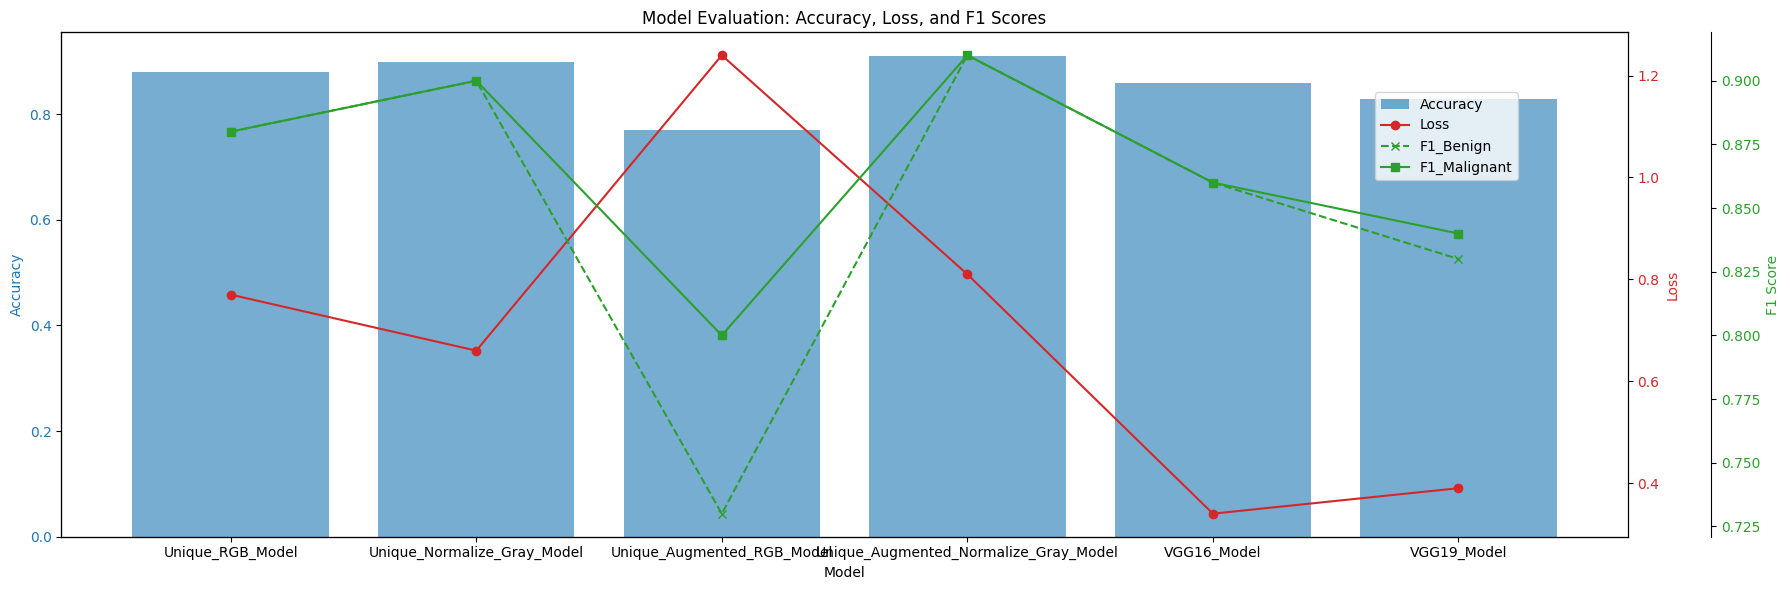

In [61]:
# Plotting the evaluation results
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plotting Accuracy
ax1.set_title('Model Evaluation: Accuracy, Loss, and F1 Scores')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.bar(evaluation_df['Model'], evaluation_df['Accuracy'], color='tab:blue', alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Creating a second y-axis to plot Loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(evaluation_df['Model'], evaluation_df['Loss'], color='tab:red', marker='o', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Creating a third y-axis to plot F1 Scores
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('F1 Score', color='tab:green')
ax3.plot(evaluation_df['Model'], evaluation_df['F1_Benign'], color='tab:green', marker='x', linestyle='--', label='F1_Benign')
ax3.plot(evaluation_df['Model'], evaluation_df['F1_Malignant'], color='tab:green', marker='s', linestyle='-', label='F1_Malignant')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Adding legends
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

# Display the plot
plt.xticks(rotation=45)
plt.show()


Found 999 images belonging to 2 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step


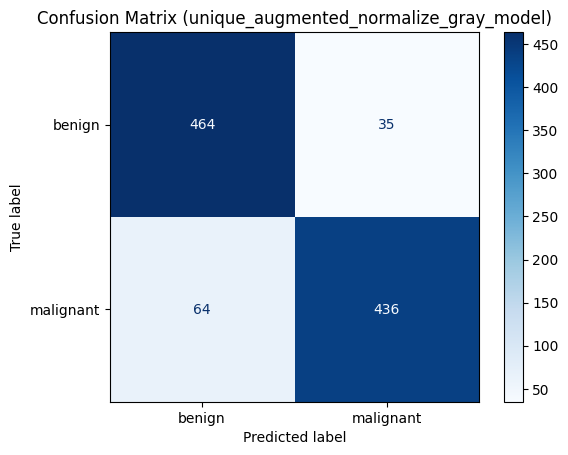

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_dir):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        color_mode='rgb' if model.input_shape[-1] == 3 else 'grayscale',
        shuffle=False
    )
    
    # Get the true labels and predictions
    true_labels = test_generator.classes
    predictions = model.predict(test_generator)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (unique_augmented_normalize_gray_model)')
    plt.show()

# Plot confusion matrix for one of the models, e.g., Unique_RGB_Model
plot_confusion_matrix(unique_augmented_normalize_gray_model, unique_augmented_normalize_gray_dataset['test'])


Based on this comparison:

- **Unique_Augmented_Normalize_Gray_Model** is the best considering both high accuracy and relatively low loss.
- **Unique_Normalize_Gray_Model** is also strong with the lowest loss but slightly lower accuracy.
- **VGG16_Model** and **VGG19_Model** perform well in terms of loss but have lower accuracy compared to the top models.


## Summary and Conclusion of the Unique Augmented Normalize Gray Model


### Summary
The Unique Augmented Normalize Gray Model was trained using a dataset of melanoma images that were first converted to grayscale and then augmented to increase the diversity of the training data. The model architecture included several convolutional layers with batch normalization and L2 regularization to improve generalization and prevent overfitting. The model was trained for 5 epochs with early stopping and learning rate reduction callbacks to optimize performance.

### Evaluation Metrics
- **Loss:** 0.81
- **Accuracy:** 0.91
- **F1 Score (Benign):** 0.91
- **F1 Score (Malignant):** 0.91

### Conclusion
The Unique Augmented Normalize Gray Model demonstrated strong performance with an accuracy of 91% and balanced F1 scores for both benign and malignant classes. The model effectively handled the grayscale images and benefited from the augmentation process, resulting in high generalization capability. This model is suitable for deployment in melanoma detection tasks, providing reliable and accurate predictions.
